# Mothers’ Lifestyle Characteristics Impact on Infant Birth Weight

Team B1: Ayingfu (#82951880), Bryant Hartono (#66162710), Jeremy Davies (#74883935), Jingxuan Ma (#49183288)

## 1. Introduction

#### 1.1 Data Source

The dataset for this project is the “birthwt” dataset provided with the Support Functions and Datasets for Venables and Ripley's MASS package in R.

Relevant citation for the MASS package:  
Venables WN, Ripley BD (2002). Modern Applied Statistics with S, Fourth edition. Springer, New York. ISBN 0-387-95457-0, https://www.stats.ox.ac.uk/pub/MASS4/.

#### 1.2 Dataset Description

**Dataset detail**  
The dataset consists of 189 observations with 10 columns (refer to column details explained below). Data was collected at Baystate Medical Center, Springfield, Massachusetts during 1986, with no specific setting. Study subjects were 189 mothers, 59 of which had low birth weight babies and 130 of which had normal birth weight babies. Characteristics of the mother’s lifestyle and health factors were collected during the pregnancy and the weight of the newborn infant was recorded at birth.

**Response variable**  
Neonate birth weight (‘bwt’), measured in grams.

**Potential explanatory variables**  
1) Continuous variables  
- age: Mother’s age (years)
- lwt: Mother's weight (pounds) at last menstrual period
- ptl: Number of previous premature labors
- ftv: Number of physician visits during the first trimester  
  
2) Categorical variables  
- race: Mother's race ( “1” = white, “2” = black, “3” = other) 
- smoke: Smoking status during the pregnancy. (“1”=Yes,”0”= No)
- ht: History of hypertension. (“1”=Yes,”0”= No)
- ui: Presence of uterine irritability. (“1”=Yes,”0”= No)

#### 1.3 Research Question / Motivation

There is some evidence (and some speculation) to suggest that heavier babies have lower infant mortality rates and perhaps also lower risk of cardiovascular disease later in life. Therefore, our group is interested in studying the factors that explain an infant’s birth weight. In particular, we are interested in whether the weight of the mother, the mother’s race, the smoking status of the mother, among other variables, affect the infant birth weight.  
  
If we can identify the contributing factors and reasonably predict a baby’s neonate birth weight, this would enable better preparation of healthcare at birth. For example, if we develop a model that predicts a baby will have a low birth weight, then the obstetrician could recommend for the mother to have the birth at a dedicated neonatal ward, where there are more specialized resources to ensure a healthy birth.

## 2. Analysis

#### 2.1 Reading in data

In [2]:
# Necessary libraries to install:
# - 'tidyverse', 'cowplot' , 'tidymodels', 'repr', 'MASS', 'leaps', 'GGally'
  
# Load in libaries
library(tidyverse)
library(cowplot)
library(tidymodels)
library(repr)
library(MASS)
library(GGally)
library(leaps)


# Suppress table outputs to a manageable # of rows
options(repr.matrix.max.rows = 10)

# Read data
raw_data <- birthwt

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

-- Attaching packages ------------------------------------------------------------------------------ tidymodels 0.1.2 --

v broom     0.7.12     v recipes   0.1.15
v dials     0.1.0      v rsample   0.1.1 
v infer     1.0.0      v tune      0.1.3 
v modeldata 0.1.1      v workflows 0.2.2 
v parsnip   0.2.1      v yardstick 0.0.8 

-- Conflicts -------------------------------------------------------------------------

#### 2.2 Clean and wrangle data

In [3]:
# Select only potentially meaningful columns (variables) and re-name categorical levels for easier understanding
data_bwt <- raw_data %>%
    dplyr::select(age, lwt, ptl, ftv, race, smoke, ht, ui, bwt) %>%
    mutate(race = case_when(
      race == 1  ~ "White",
      race == 2  ~ "Black",
      TRUE       ~ "Other"
    ), 
    smoke = case_when(smoke == 0  ~ "No", smoke == 1  ~ "Yes"), 
    ht = case_when(ht == 0  ~ "No", ht == 1  ~ "Yes"),
    ui = case_when(ui == 0  ~ "No", ui == 1  ~ "Yes")
)

# Convert categorical variables to factors in R
data_bwt$race <- as.factor(data_bwt$race)
data_bwt$smoke <- as.factor(data_bwt$smoke)
data_bwt$ht <- as.factor(data_bwt$ht)
data_bwt$ui <- as.factor(data_bwt$ui)

#  relevel race based on highest observation count
data_bwt$race <- relevel(data_bwt$race, ref="White")  

# Inspect clean dataframe
head(data_bwt,5)

,age,lwt,ptl,ftv,race,smoke,ht,ui,bwt
,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<int>
85,19,182,0,0,Black,No,No,Yes,2523
86,33,155,0,3,Other,No,No,No,2551
87,20,105,0,1,White,Yes,No,No,2557
88,21,108,0,2,White,Yes,No,Yes,2594
89,18,107,0,0,White,Yes,No,Yes,2600


#### 2.3 Tabular Summary of Data

In [4]:
summary(data_bwt)

      age             lwt             ptl              ftv            race   
 Min.   :14.00   Min.   : 80.0   Min.   :0.0000   Min.   :0.0000   White:96  
 1st Qu.:19.00   1st Qu.:110.0   1st Qu.:0.0000   1st Qu.:0.0000   Black:26  
 Median :23.00   Median :121.0   Median :0.0000   Median :0.0000   Other:67  
 Mean   :23.24   Mean   :129.8   Mean   :0.1958   Mean   :0.7937             
 3rd Qu.:26.00   3rd Qu.:140.0   3rd Qu.:0.0000   3rd Qu.:1.0000             
 Max.   :45.00   Max.   :250.0   Max.   :3.0000   Max.   :6.0000             
 smoke       ht        ui           bwt      
 No :115   No :177   No :161   Min.   : 709  
 Yes: 74   Yes: 12   Yes: 28   1st Qu.:2414  
                               Median :2977  
                               Mean   :2945  
                               3rd Qu.:3487  
                               Max.   :4990  

#### 2.4 Visual Summary of Data

##### 2.4.1 Scatterplot grid for numeric variables vs. birthweight

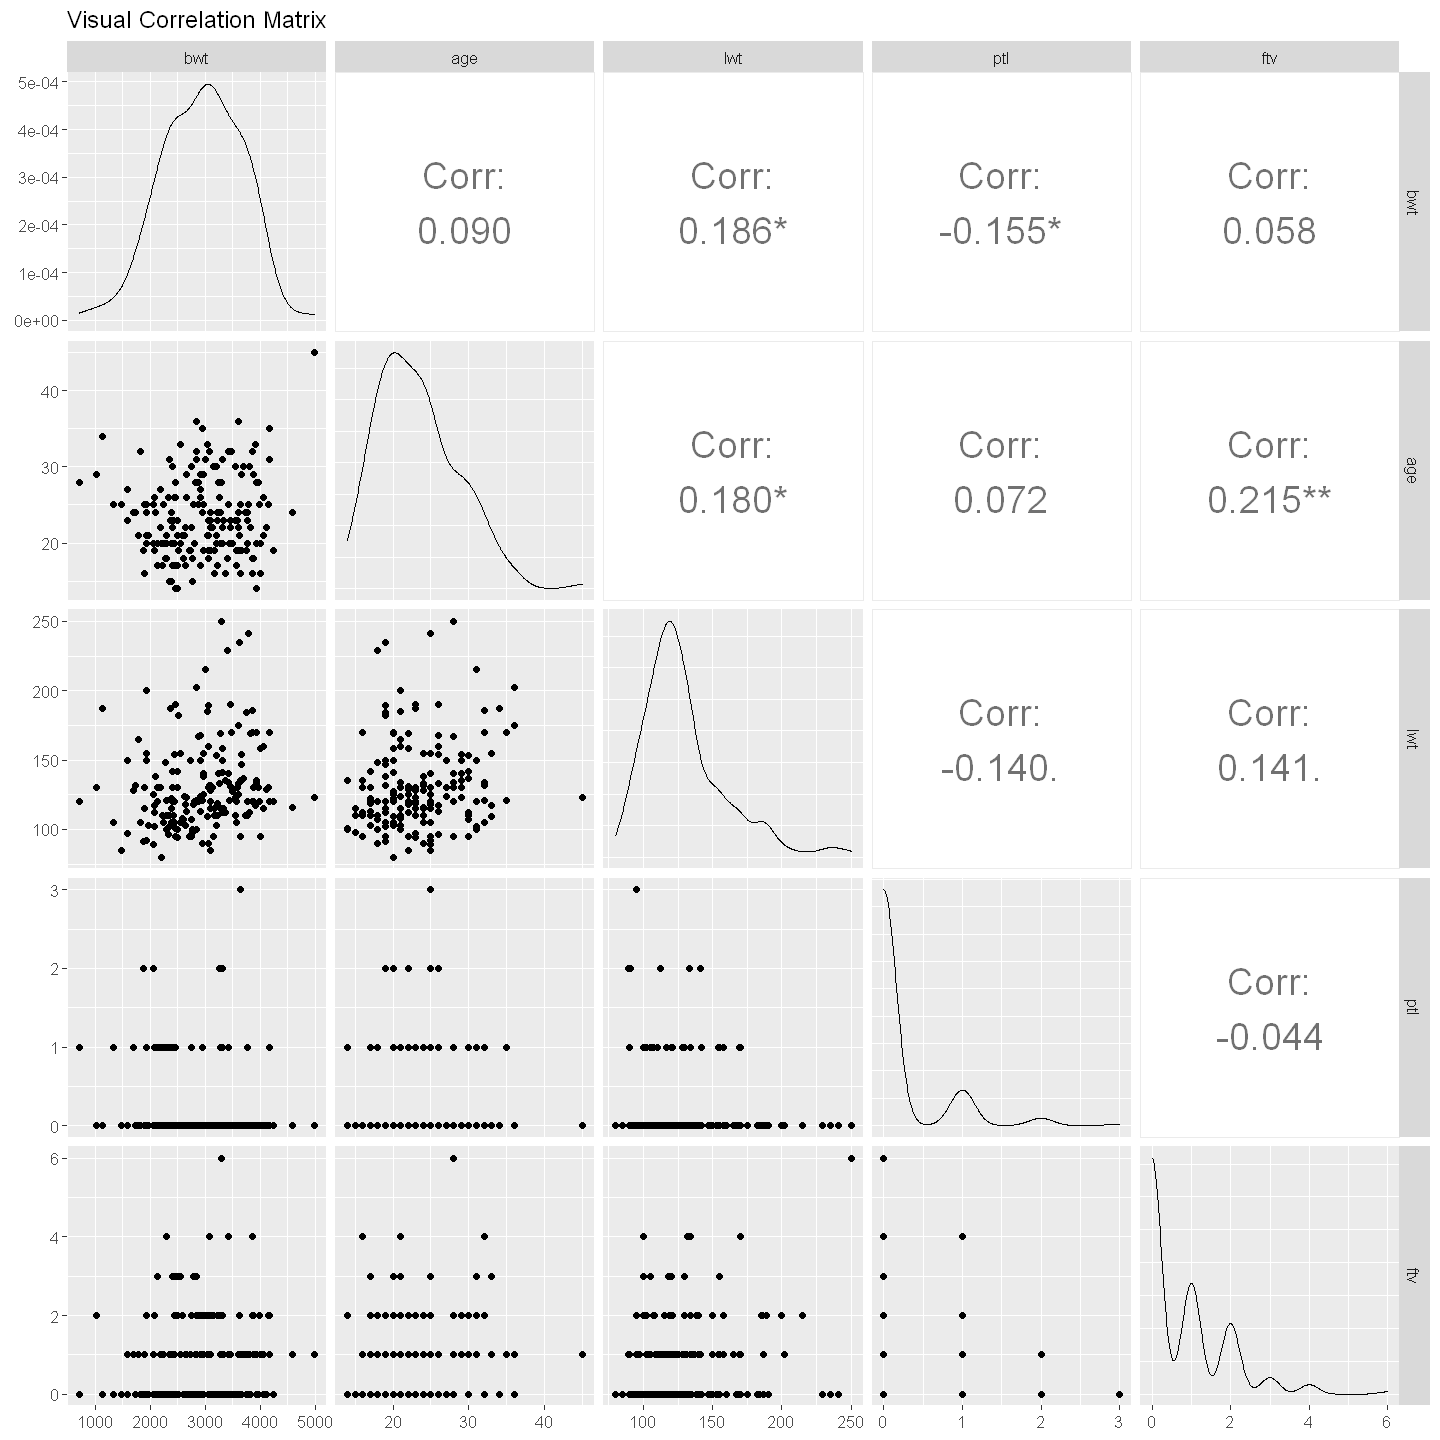

In [5]:
# Set plot output size
options(repr.plot.width = 12, repr.plot.height = 12)

# Get df with only the numeric variables (exclude factor vars for now)
data_bwt_numeric <- data_bwt %>%
    dplyr::select(bwt, age, lwt, ptl, ftv)
    

# Construct visual correlation matrix of only numeric variables
# PURPOSE: Explore correlations between explanatory variables themselves and with response variable bwt (birthweight)
ggpairs(data_bwt_numeric,
        title = "Visual Correlation Matrix",
         upper = list(continuous = wrap("cor", size = 8)))  +
theme(text = element_text(size=12))

**Comments**  
- The baby's birth weight has a weak, positive correlation with with the mother's weight at the last menstrual period (r=0.186). This makes intuitive sense because we would expect on average that mothers of larger stature tend to have larger newborn babies.
- The baby's birth weight has a weak, positive correlation with the mother's age (r=0.09).
- The baby's birth weight has a weak, negative correlation with the number of previous premature labours (r=-0.155). This indicates that a mother who was prone to premature labours in the past may be prone to it again.
- We also remark the presence of collinearity between explanatory variables of mother's age and # of physician visits in the first trimester (r=0.215), and the mother's age and her weight (r=0.18). We will bear these trends in mind when fitting linear models in later sections of this report. 
  
Note: The diagonal terms of the above chart represent a distribution of each respective numeric variable.

##### 2.4.1 Comparing baby birthweight by category

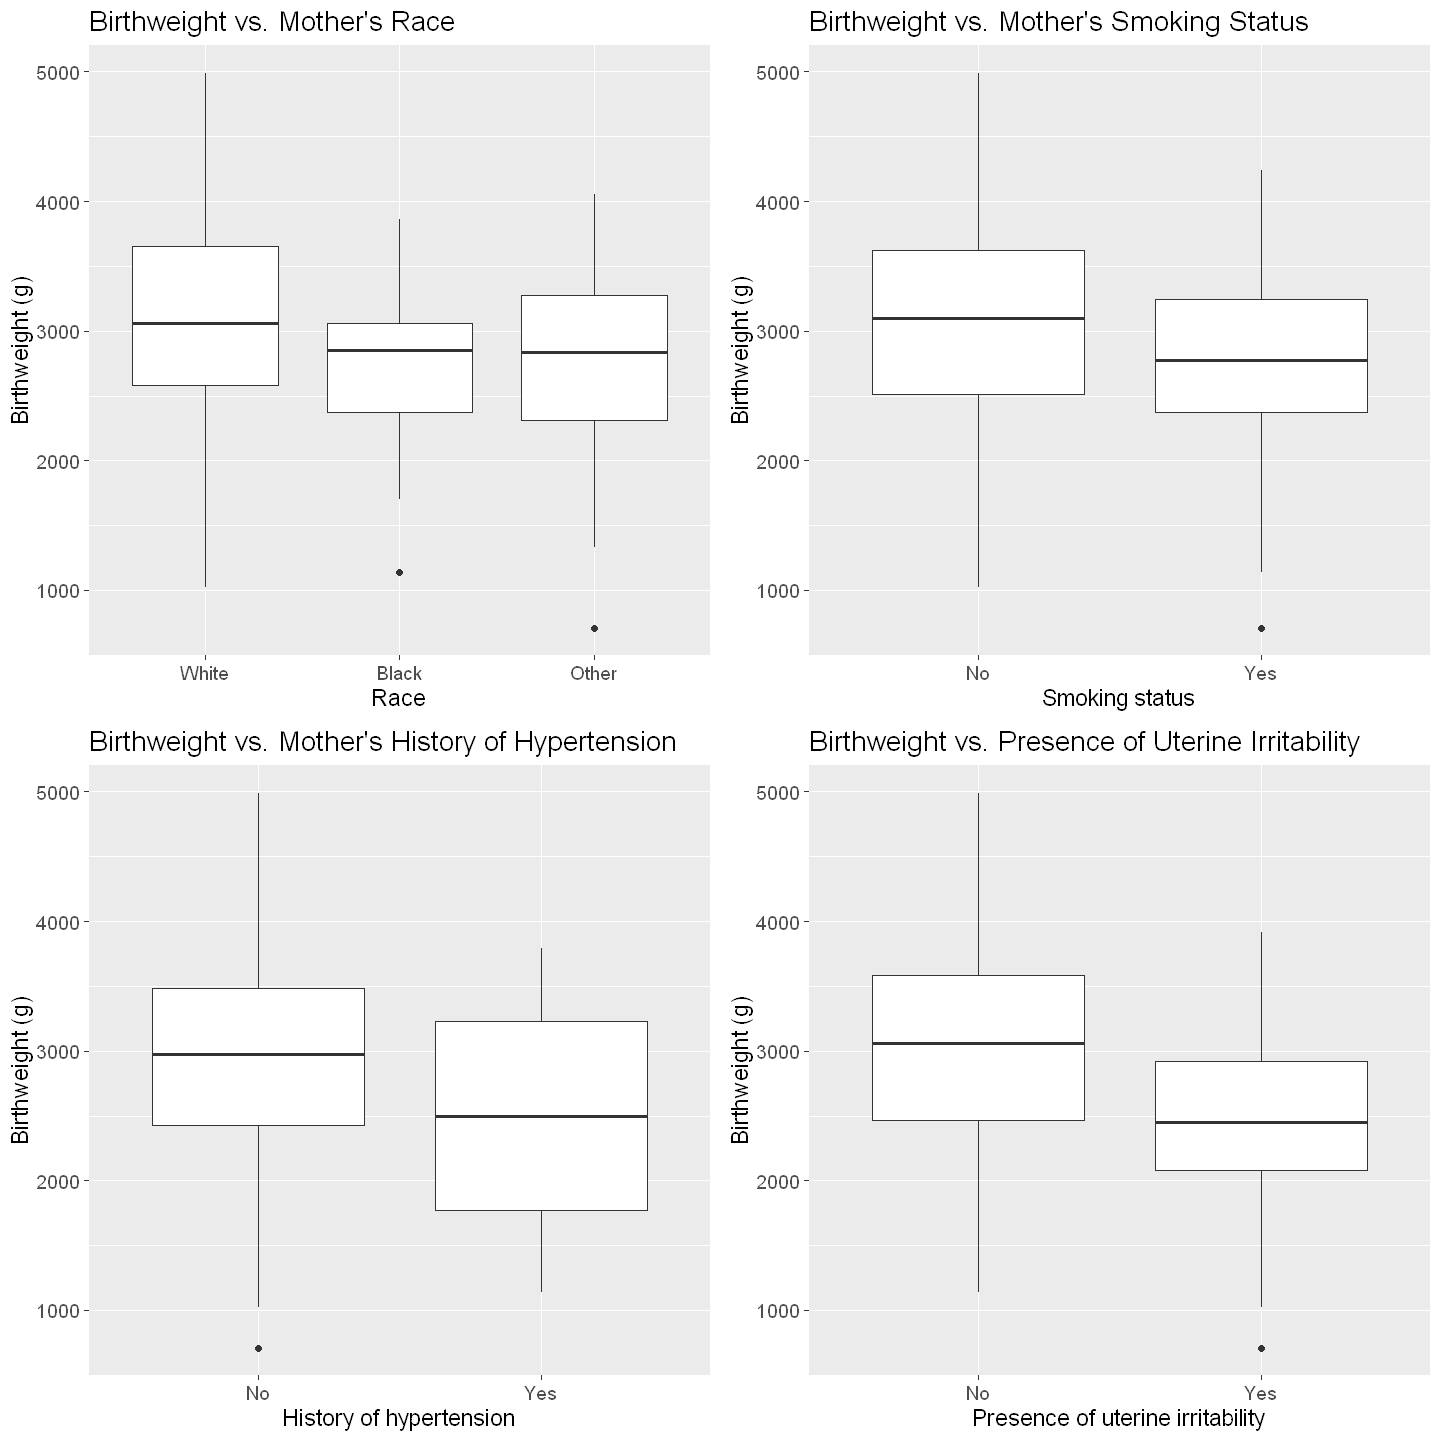

In [6]:
# Set plot output size
options(repr.plot.width = 12, repr.plot.height = 12)

# Get df with only the categorical variables
data_bwt_categorical <- data_bwt %>%
    dplyr::select(bwt,race, smoke, ht, ui)
    

# Construct boxplots showing btw against the various levels of the categorical variables
# PURPOSE: Explore distributions of various levels of different categorical explanatory variables
p_race <- data_bwt_categorical%>%
     ggplot(aes(x=race, y=bwt)) + 
             geom_boxplot() + theme(text = element_text(size=14)) + 
             labs(x = "Race", y="Birthweight (g)", title= "Birthweight vs. Mother's Race")
p_smoke<- data_bwt_categorical%>%
     ggplot(aes(x=smoke, y=bwt)) + 
             geom_boxplot() + theme(text = element_text(size=14)) + 
             labs(x = "Smoking status", y="Birthweight (g)", title= "Birthweight vs. Mother's Smoking Status")
p_ht<- data_bwt_categorical%>%
     ggplot(aes(x=ht, y=bwt)) + 
             geom_boxplot() + theme(text = element_text(size=14)) + 
             labs(x = "History of hypertension", y="Birthweight (g)", title= "Birthweight vs. Mother's History of Hypertension")
p_ui<- data_bwt_categorical%>%
     ggplot(aes(x=ui, y=bwt)) + 
             geom_boxplot() + theme(text = element_text(size=14)) + 
             labs(x = "Presence of uterine irritability", y="Birthweight (g)", title= "Birthweight vs. Presence of Uterine Irritability")
plot_grid(p_race,p_smoke,p_ht,p_ui)

**Comments**   
- The baby's median birth weights are approximately equal among mothers who are black and other races, while white mothers' baby birth weight appears to be about 100g higher than other races on average. Both black and other races mothers have several babies with extremely low birth weight, shown as outliers in the boxplots. Further, the ranges are narrower comparing to babies from white mothers with about half of the spread. This difference suggests that we may want to include mother's race in our model.
- Mothers who do not smoke during the pregnancy have babies with about 500 grams higher mean birth weights and wider spread than mothers who smoke during the pregnancy. This is in line with expectations because we know that smoking is not healthy for natal development.
- Mothers history of hypertension have babies with about 300 grams lower median birth weights. Thus, we believe history of high blood pressure could be a good predictive variable to include in our model.
- Finally, mothers with no presence of uterine irritability have babies with about 500 grams higher median birth weights. Again, this difference suggests that this is also a variable to explore.

#### 2.5 Model Selection

In this section, we perform analysis to fit and compare models in order to determine a "best" predictive model. In particular, we employ two model selection methods: best subsets method and 2-fold cross validation.

##### 2.5.1 Best Subsets Selection

In [7]:
#Compute the best subset selection.
#PURPOSE: Use best subset selection to find the best model with different number of variables.
model_selection<- regsubsets(bwt~., data=data_bwt, method="exhaustive")
summary_selection <- summary(model_selection)
summary_selection
#Compute values of each selection statistic for the best models with different number of variables.
#PURPOSE: Select the best model over all possible models based on R^2, Adjusted R^2, and Cp criteria.
selection_statistic<-data.frame(summary_selection$rsq,summary_selection$adjr2,summary_selection$cp)

names(selection_statistic)[names(selection_statistic) == "summary_selection.adjr2"] <- "Adjusted R^2"
names(selection_statistic)[names(selection_statistic) == "summary_selection.cp"] <- "Cp"
names(selection_statistic)[names(selection_statistic) == "summary_selection.rsq"] <- "R^2"
selection_statistic


Subset selection object
Call: regsubsets.formula(bwt ~ ., data = data_bwt, method = "exhaustive")
9 Variables  (and intercept)
          Forced in Forced out
age           FALSE      FALSE
lwt           FALSE      FALSE
ptl           FALSE      FALSE
ftv           FALSE      FALSE
raceBlack     FALSE      FALSE
raceOther     FALSE      FALSE
smokeYes      FALSE      FALSE
htYes         FALSE      FALSE
uiYes         FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         age lwt ptl ftv raceBlack raceOther smokeYes htYes uiYes
1  ( 1 ) " " " " " " " " " "       " "       " "      " "   "*"  
2  ( 1 ) " " " " " " " " " "       " "       " "      "*"   "*"  
3  ( 1 ) " " "*" " " " " " "       " "       " "      "*"   "*"  
4  ( 1 ) " " " " " " " " "*"       "*"       "*"      " "   "*"  
5  ( 1 ) " " " " " " " " "*"       "*"       "*"      "*"   "*"  
6  ( 1 ) " " "*" " " " " "*"       "*"       "*"      "*"   "*"  
7  ( 1 ) " " "*" "*" " " "*"       "*"

R^2,Adjusted R^2,Cp
<dbl>,<dbl>,<dbl>
0.08061477,0.07569828,32.324944
0.11225032,0.10270463,26.846910
0.14782772,0.13400871,20.437098
0.18905712,0.17142793,12.691264
0.21364404,0.19215891,8.879389
0.24039446,0.21535251,4.556107
0.24156847,0.21223686,6.278594
0.24235985,0.20868696,8.091525


**Comment**
- The selection statistics indicate that the model with 5 predictors, **lwt, race, smoke, ui, and ht** has the largest adjusted R^2 and the smallest Cp statistic (Cp = 4.56) that is close to the number of predictions. We also remark that R^2 nearly stops increasing in the models subsequent to the "best" model, indicating that adding more variables than the chosen 5 does not add very much explanatory power.

##### 2.5.2 Two-fold Cross Validation

In [8]:
#PURPOSE: Use 2-fold cross validation to compare the model with and without the numerical variable, lwt
#Compute the 2-fold cross validation error of the model contains race, smoke, ui, and ht as predictors
train <- 1:as.integer(dim(data_bwt)[1]/2)
reg1 <- lm(bwt~race+smoke+ui+ht, data=data_bwt[train,])
error1 <- sum((data_bwt$bwt[-train] - predict(reg1, data_bwt[-train,]))^2)
reg2 <- lm(bwt~race+smoke+ui+ht, data=data_bwt[-train,])
error2 <- sum((data_bwt$bwt[train] - predict(reg2, data_bwt[train,]))^2)
error_without_lwt <- (error1 + error2)/dim(data_bwt)[1]
paste("Error without lwt:", as.character(round(error_without_lwt,1)), sep=" ")
#Compute the 2-fold cross validation error of the model contains lwt, race, smoke, ui, and ht as predictors
reg11 <- lm(bwt~lwt+race+smoke+ui+ht, data=data_bwt[train,])
error11 <- sum((data_bwt$bwt[-train] - predict(reg11, data_bwt[-train,]))^2)
reg22 <- lm(bwt~lwt+race+smoke+ui+ht, data=data_bwt[-train,])
error22 <- sum((data_bwt$bwt[train] - predict(reg22, data_bwt[train,]))^2)
error_with_lwt <- (error11 + error22)/dim(data_bwt)[1]
paste("Error with lwt:", as.character(round(error_with_lwt,1)), sep=" ")

[1] "Error without lwt: 684199.5"

[1] "Error with lwt: 681045.2"

**Comments**
- 2-fold cross validation is used to compare the top two models indicated by the selection statistics which are the model with lwt, race, smoke, ui, and ht as predictors versus the model containing race, smoke, ui, and ht as predictors. The results shows that the model with lwt has a smaller error than the one without.

- However, the difference in the error is only about 0.5%, so it is not that significant of a difference between the top two models. Additionally, we believe the mother’s weight is an important variable to include because it is very interpretable, has some correlation with the infant's birthweight, and is a low barrier measurement for hospitals to obtain that can help in predicting baby birth weight. Most importantly, lwt is a signficant variable at the 2% significance level (refer to section 2.5.3).

- Therefore, considering all quantitative and contextual factors, we select the model that contains one numerical variable **lwt** and four categorical variables **race, smoke, ui, and ht** as our model to predict the baby's birth weight.

##### 2.5.3 Summary of Chosen Model

In [9]:
model<- lm(bwt~lwt+race+smoke+ui+ht, data=data_bwt)
summary<-summary(model)
summary


Call:
lm(formula = bwt ~ lwt + race + smoke + ui + ht, data = data_bwt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1842.14  -433.19    67.09   459.21  1631.03 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2837.264    243.676  11.644  < 2e-16 ***
lwt            4.242      1.675   2.532 0.012198 *  
raceBlack   -475.058    145.603  -3.263 0.001318 ** 
raceOther   -348.150    112.361  -3.099 0.002254 ** 
smokeYes    -356.321    103.444  -3.445 0.000710 ***
uiYes       -525.524    134.675  -3.902 0.000134 ***
htYes       -585.193    199.644  -2.931 0.003810 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 645.9 on 182 degrees of freedom
Multiple R-squared:  0.2404,	Adjusted R-squared:  0.2154 
F-statistic:   9.6 on 6 and 182 DF,  p-value: 3.601e-09


**Model Fitted**  
Based on our analysis, the best model to predict a baby's neonate birth weight consists of the following 5 factors associated to the birth mother:
- weight in their last menstrual period (lwt)  # continuous variable
- race (race)                                  # raceBlack = 1 if "black", otherwise 0.  raceOther = 1 if "other", otherwise 0. Reference is "white".
- smoking status during pregnancy (smoke)      # 1 if mother is a smoker, otherwise 0
- history of hypertension (ht)                 # 1 if yes, otherwise 0
- presence of uterine irritability (ui)        # 1 if yes, otherwise 0


$Y = 2837.26 + 4.242*lwt - 475.058*raceBlack - 348.150*raceOther - 356.321*smokeYes - 525.524*uiYes - 585.193*htYes + error$

**Comments**
- The coefficients in the selected model are significantly different from zero at the 2% level
- As we hypothesized in section 2.4, mothers of black or "other" race tend to have lighter babies on average than white mothers. This may be due to socioeconomic factors and better access to healthcare for white mothers because in the United States (where this study was performed) people of colour have historically had less socioeconomic benefits than caucausian residents.
- Additionally, the model predicts that mothers who are smokers tend to have smaller babies. Since underweight babies may not be as healthy, this means that doctors should advise pregnant patients to not smoke during the pregnancy.
- Similarly, the model predicts that mothers will uterine irritability tend to birth smaller babies. This is also the case for mothers with a history of hyptertension. The implication here is that healthcare providers should be more careful in pregnancies with mothers of these conditions.

#### 2.6 Residual Plot Analysis

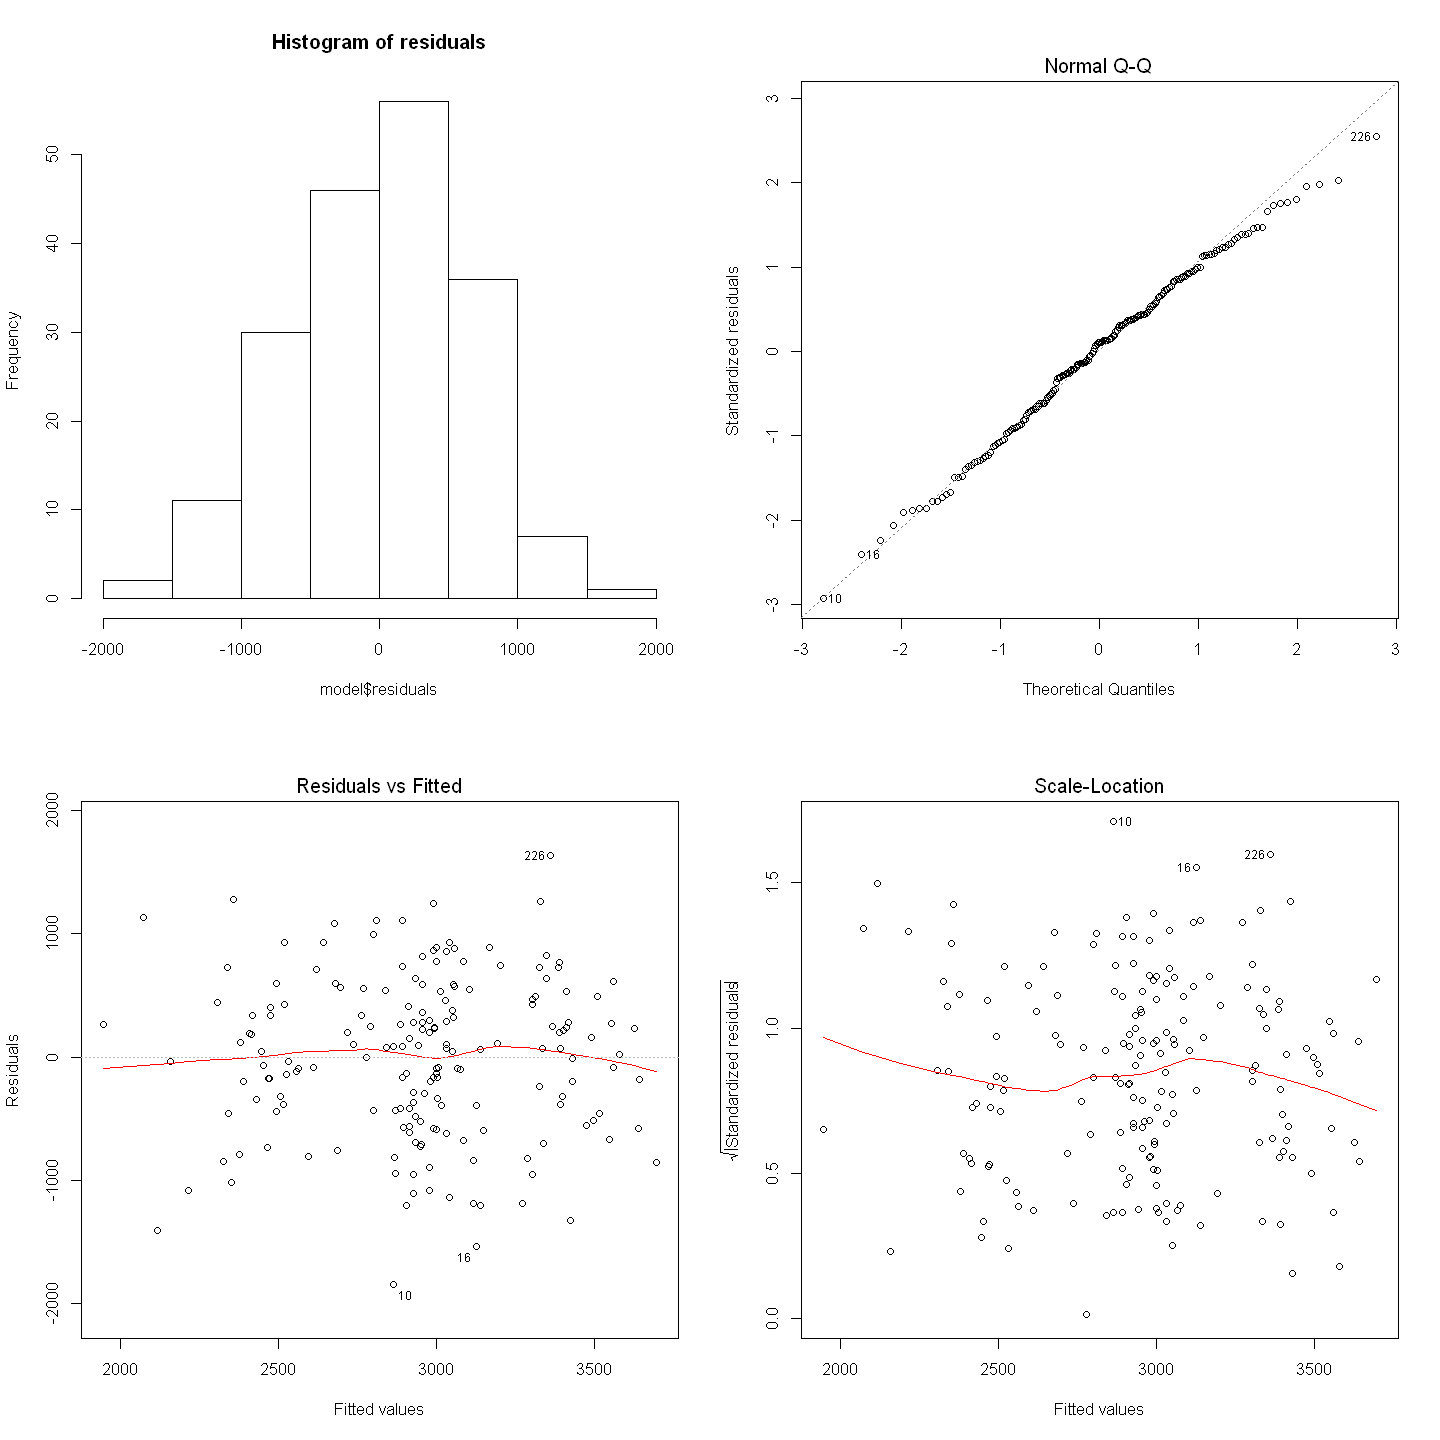

In [10]:
# The "best"model from selection
par(mfrow = c(2, 2)) 
model<- lm(bwt~lwt+race+smoke+ui+ht, data=data_bwt)
#Histogram
r1<-hist(model$residuals,main="Histogram of residuals")
#Normality check
r2<-plot(model, which = 2)
#Residuals vs Fitted Plot
r3<-plot(model, which = 1)
#Homoscedasticity check
r4<-plot(model, which = 3)

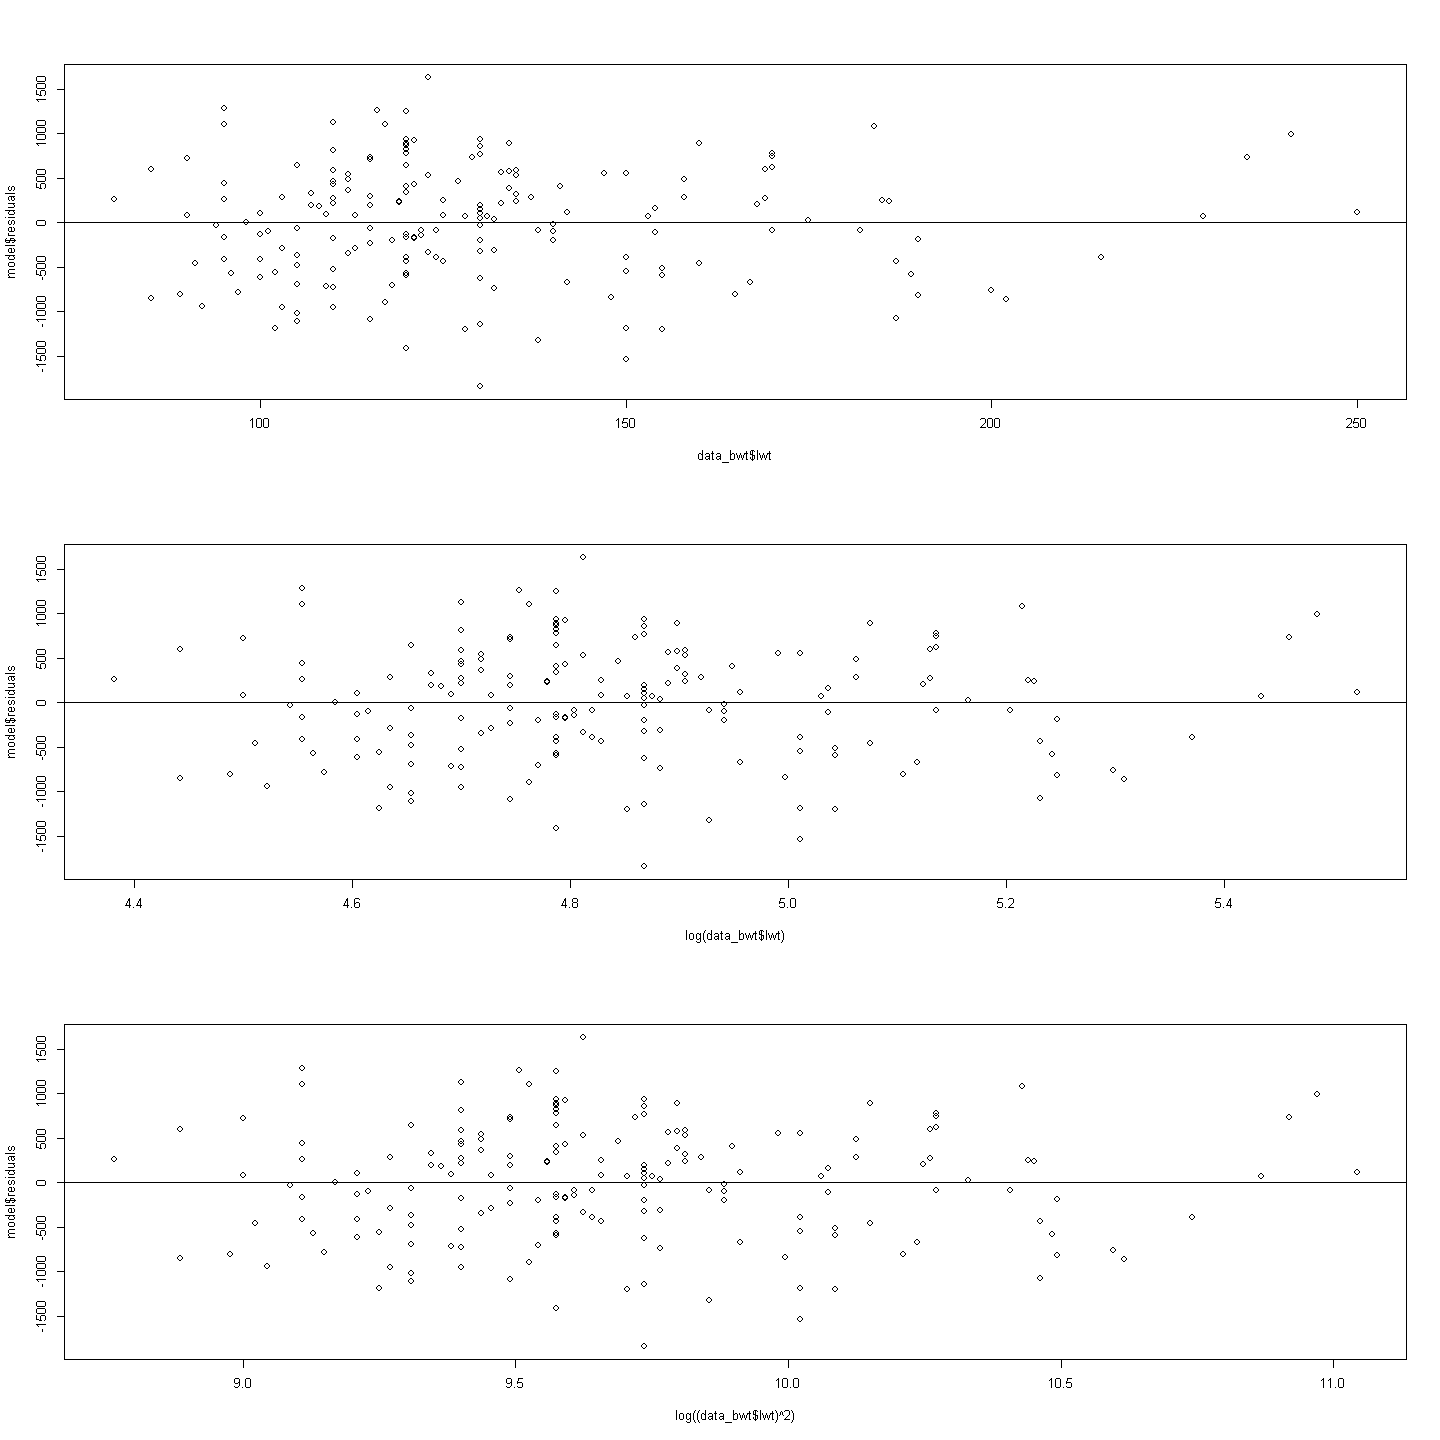

In [11]:
#Residual against numerical predictor
par(mfrow = c(3, 1)) 
plot(data_bwt$lwt,model$residuals)
abline(0,0)
#Log transfromation for lwt
plot(log(data_bwt$lwt),model$residuals)
abline(0,0)
#Quadratic transfromation for lwt
plot(log((data_bwt$lwt)^2),model$residuals)
abline(0,0)

**Comments**
- **Normality assumption:** The histogram of residuals suggest that residuals follow a normal distribution. We can observed from the Normal Q–Q Plot that residuals follow a almost straight line on this plot,  which is an indicator for normal distribution. And no outliers observed. We may conclude that normality assumption is valid for "best" model selected.

- **Residuals vs Fitted Plot:** Residuals spread randomly around the 0, which means residuals and fitted values are not correlated. And no any patterns observed from the plot.

- **Homoscedasticity:** From Scale-location plot, The Square root of standardized residuals seems to spread equally along the Horizontal line, which indicating a constant variances in the residuals. We may conclude that assumption of equal variance is valid.


- **Residual against numerical predictor:** We noticed that Residual against numerical predictor is not quite randomly distributed. After performing Log and Quadratic transformation for **lwt**, the plot does not improved much. The result consistent with the Model selection part that mother’s weight is a low barrier measurement for predicting baby birth weight. 

#### 2.7 Leverage

,hatvalues(model)
,<dbl>
85,0.09016420
86,0.02501746
87,0.02105393
88,0.04614246
89,0.04630769
⋮,⋮
79,0.02490693
81,0.02041031
82,0.03758353


Top 20 highest leverage observations in descending order:

[1] 0.16 0.14 0.14 0.12 0.12 0.11 0.11 0.11 0.10 0.10 0.10 0.10 0.10 0.10 0.09
[16] 0.09 0.08 0.07 0.07 0.07

Average of all hat diagonal values:

[1] 0.037

Two times the average of all hat values (reference point):

[1] 0.074

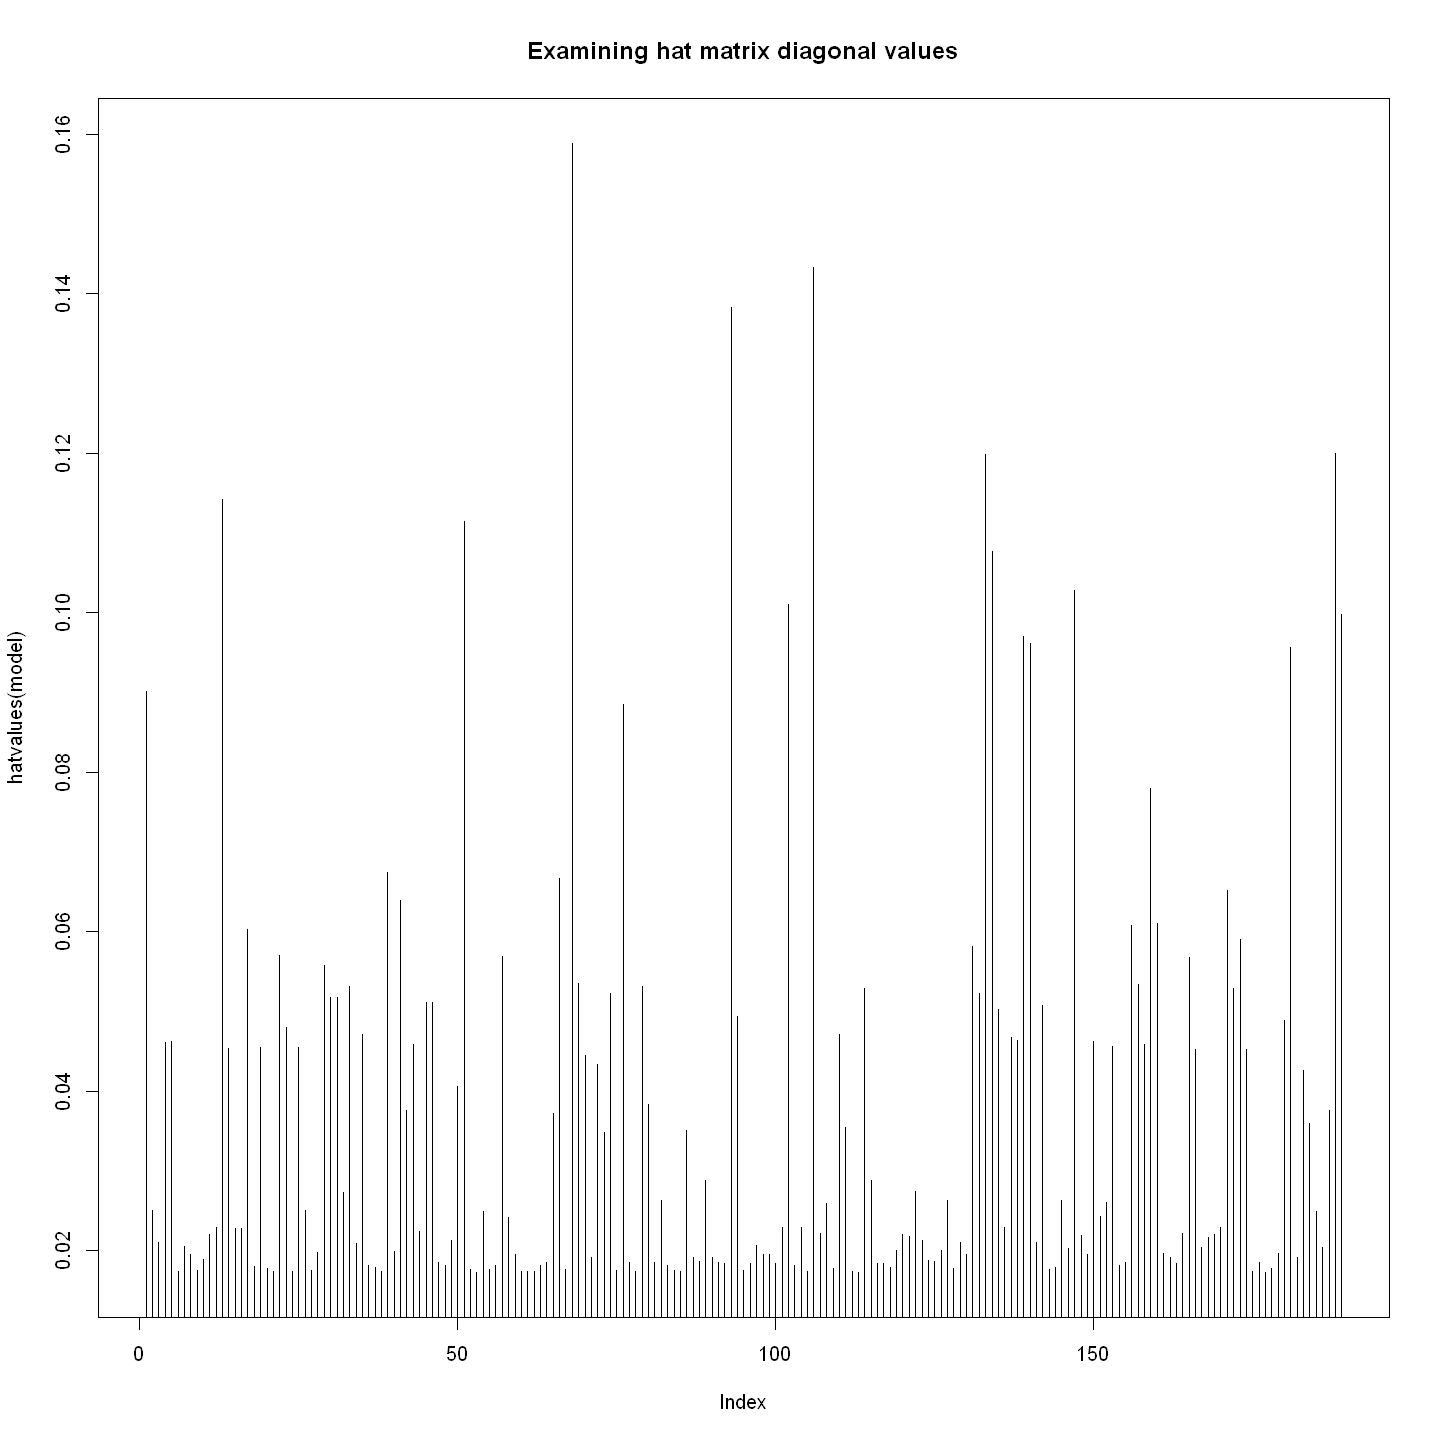

In [34]:
#calculating the leverage for each observation
hats <- as.data.frame(hatvalues(model))
hats

#sort observations by leverage in  a descending order
cat("Top 20 highest leverage observations in descending order:")
head(round(hats[order(-hats['hatvalues(model)']),],2), n = 20)

#average hatvalues
cat("Average of all hat diagonal values:")
round(mean(hatvalues(model)),3)

#plot leverage values for each observation
plot(hatvalues(model), type ='h', main = "Examining hat matrix diagonal values")

#average value of hatvalues
cat("Two times the average of all hat values (reference point):")
round(mean(hatvalues(model))*2, 3)

#Potential hatvalues with a high leverage
high_leverage = hats[hatvalues(model) >= mean(hatvalues(model))*2, ]

**Comments**
- To investigate whether certain observations have a potential to influence the model, we analyze its leverage through calculating the hat values. In general, an observation would be considered to have a high leverage if its value is more than twice the average of the hat value (0.074). 
- The analysis suggests that there are a total of 17 observations with a considerably high leverage, with the highest and lowest value of these observations being (0.15884245) and (0.07799913), respectively. 
- Since there are values which are considered to have a high leverage, an influential analysis will be conducted. 

#### 2.8 Influence Analysis

numeric(0)

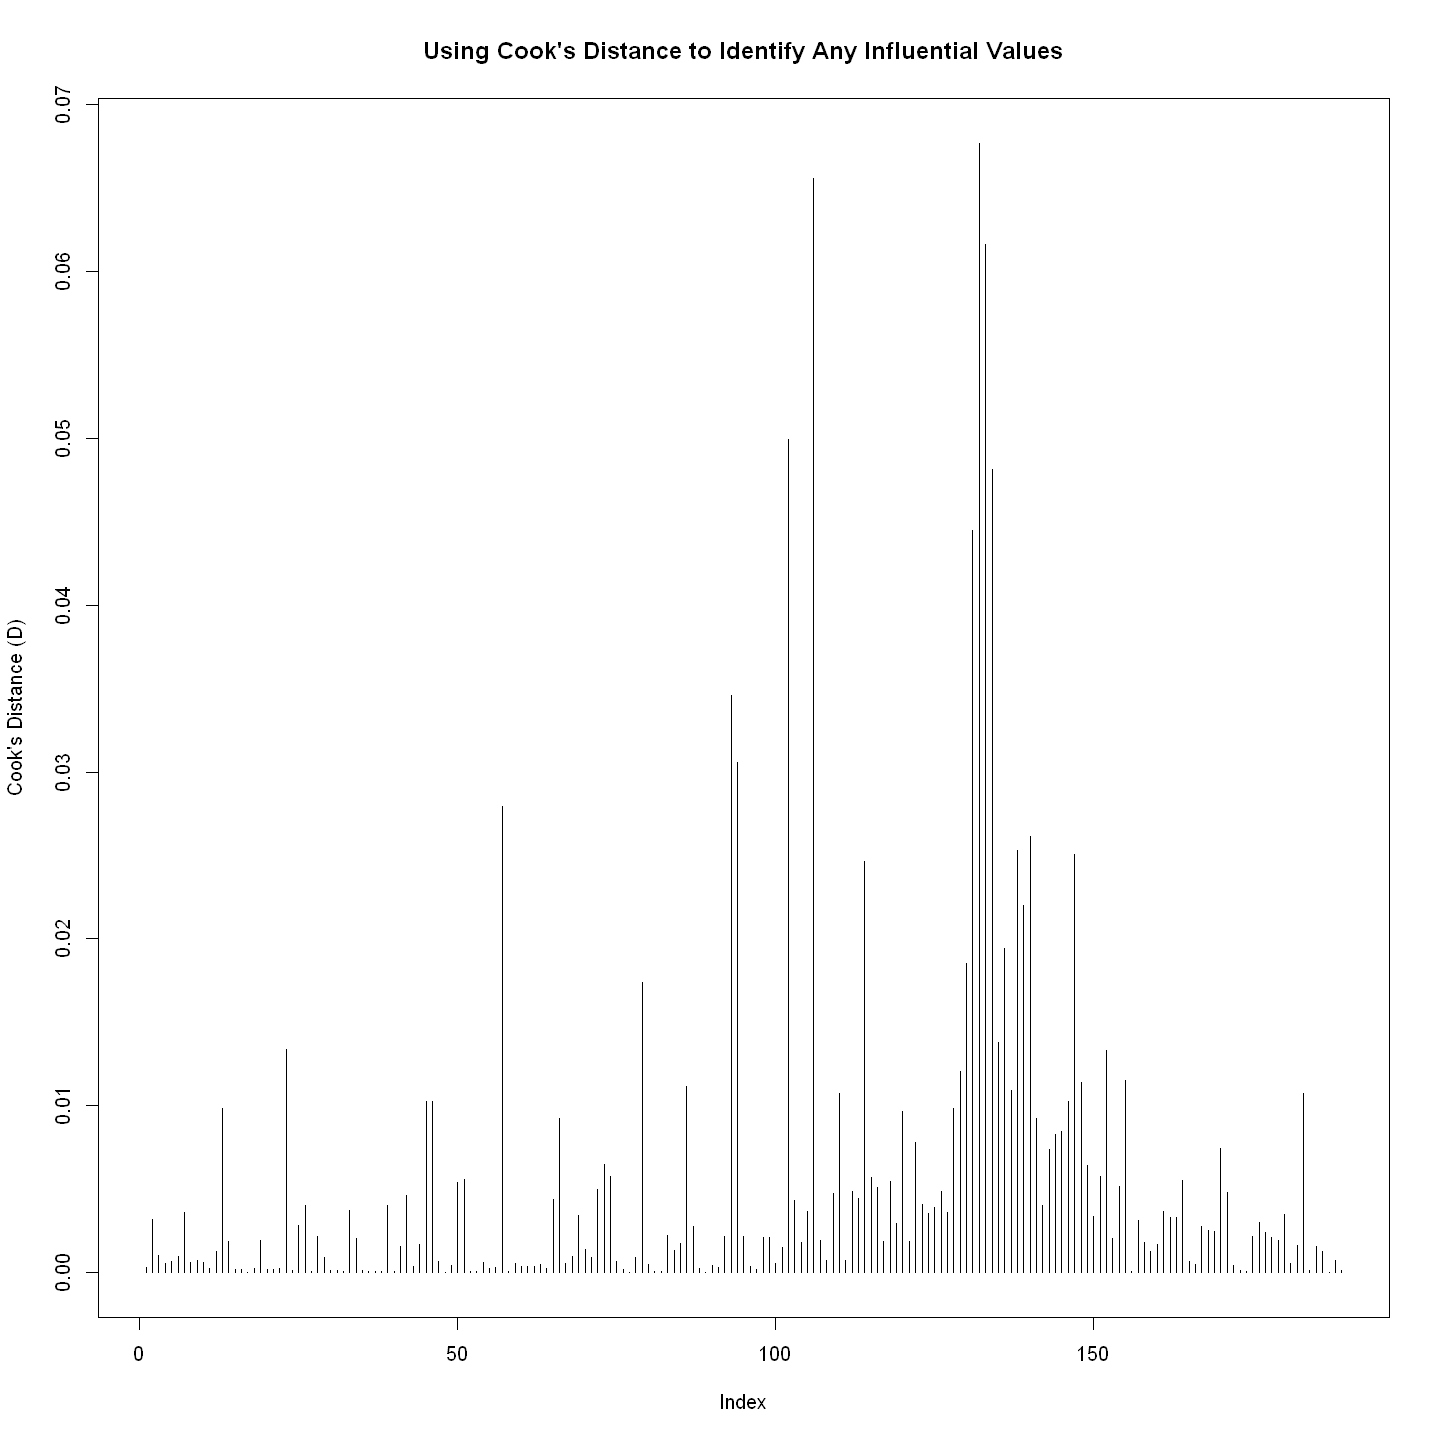

In [28]:
#Finding cooks distance values
cooks_d = cooks.distance(model)
cooks_d = as.data.frame(cooks_d)
colnames(cooks_d)[1] = "distance"

#Finding potential influential values
cooks_d[cooks_d$distance >= 1,]
plot(cooks_d$distance, type ='h', ylab = "Cook's Distance (D)", main = "Using Cook's Distance to Identify Any Influential Values")

**Comments**
- To investigate the potential influence of the observations, we assess the Cook's distance. It is suggested by authors that a value larger than 1 indicates an influential observation.
- The analysis suggests that none of the observations are influential, having the highest Cooks' distance value substantially lower than. Thus, no observations will be removed from the original data and the same model will be used.

## 3. Conclusion

In this report, we started with the birthwt dataset, then performed visual exploratory analysis, best subset and cross-fold model selection, residual analysis, and finally leverage/influence analysis. As the reader would have noticed, we injected commentary at each stage of the report to provide context and interpration to the quantitative analysis. Below we summarize and reflect upon our findings and draw real-world implications from the statistical results. 

##### 3.1 Summary of Analysis/Findings

**Model Fitted**  
Based on our analysis, the best model to predict a baby's neonate birth weight consists of the following 5 factors associated to the birth mother:
- weight in their last menstrual period (lwt)  # continuous variable
- race (race)                                  # raceBlack = 1 if "black", otherwise 0.  raceOther = 1 if "other", otherwise 0. Reference is "white".
- smoking status during pregnancy (smoke)      # 1 if mother is a smoker, otherwise 0
- history of hypertension (ht)                 # 1 if yes, otherwise 0
- presence of uterine irritability (ui)        # 1 if yes, otherwise 0


$Y = 2837.26 + 4.242*lwt - 475.058*raceBlack - 348.150*raceOther - 356.321*smokeYes - 525.524*uiYes - 585.193*htYes + error$

Even with the best model, the adjusted R-squared is still merely 0.2154. This observation suggests that there are potentially other external factors affecting the neonate birth weight. To develop a model that can be realiably applied in birth preparation, further studies are needed to explore other explanatory variables that affect neonatal birth weight. We hypothesize that additional variables (if they could be included in a dataset) that could help explain more of the variance in the birthweight response would be:
- Term length of pregnancy
- Height and weight of the father
- Economic status of the parents (net worth)
- Alcohol consumption during pregnancy

##### 3.2 Implications for Public Health and the Field of Obstetrics
The analysis produced in this report suggests that mothers with the following characteristics tend to have underweight babies relative to the average:
- Mother is a person of colour
- Mother is a smoker
- Mother has a history of hypertension
- Mother displays symptoms of uterine irritability

If a baby is substantially underweight, this has been proven to be associated with poorer health outcomes and more adverse health effects. Therefore, one major public health implication is that healthcare providers should have an enhanced mindfulness of the health of a mother and baby for people of colour in the United States, whose babies tend be more underweight on average. Historically, these people have had less access to the best healthcare. Health officials should strive to implement policies that eliminate the gap in quality of care between people of different races.

Another implication is that obstetricians should monitor mothers who carry at-risk factors for underweight babies, such as being a smoker or having a history of hypertension. Our analysis advocates for the fact that these at-risk mothers should have more specialized resources to help ensure a healthy birth.